# Types of State Schema 

As per the previous module, we have defined our State Schema using the help of `TypedDict`. But however there were two more ways where we can define the schema. They are the following: 
- Python `Dataclasses` 

- `Pydantic` (Most preferred)

Let us create schema in all the three types and do our analysis. 

## 1. Using `TypedDict` 

In [2]:
from typing import TypedDict, Literal

class TypedDictState(TypedDict):
    """A class representing the state of a TypedDict."""
    name: str
    mood: Literal["happy", "sad"]

### Defining graph using `TypedDict` schema

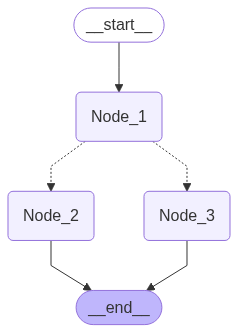

In [10]:
from langgraph.graph import START, END, StateGraph

import random 

def Node_1(state: TypedDictState): 
    print("__Node 1__")
    return { "name" : state["name"] + " is ..." }

def Node_2(state: TypedDictState):
    print("__Node 2__")
    return { "mood" : "happy" }

def Node_3(state: TypedDictState):
    print("__Node 3__")
    return { "mood" : "sad" }


# Creating function to decide which Node to go among Node 2 and Node 3. 
def decide_node(state: TypedDictState) -> Literal["Node_2", "Node_3"]: 

    if random.random() < 0.5:
        return "Node_2"
    
    return "Node_3"

# Create a state graph with TypedDictState
builder = StateGraph(TypedDictState) 

# adding nodes
builder.add_node("Node_1", Node_1)
builder.add_node("Node_2", Node_2)
builder.add_node("Node_3", Node_3)

# adding edges
builder.add_edge(START, "Node_1")
builder.add_conditional_edges("Node_1", decide_node)
builder.add_edge("Node_2", END)
builder.add_edge("Node_3", END)

graph = builder.compile()

graph 

Let's check whether the schema we defined in the first, is getting validated or not during the runtime.

For example, we have mentioned that our `name` should be string, and the `mood` variable should be any of the literals. Now, if the graph is invoked with some different data types, then we should get error as its not allowed since its not adhering to type safety.

### Scenario - 1: Providing correct data types

In [11]:
graph.invoke({"name": "Alice", "mood": "happy"})

__Node 1__
__Node 3__


{'name': 'Alice is ...', 'mood': 'sad'}

### Scenario - 2: Providing incorrect data types

Changing the data type of `name` field, and providing incorrect value outside the literal in `mood` field.

In [22]:
graph.invoke({"name": 345, "mood": "neutral"})

__Node 1__


TypeError: unsupported operand type(s) for +: 'int' and 'str'

Only providing incorrect value outside the literal in `mood` field.

In [21]:
graph.invoke({"name": "John Doe", "mood": "neutral"})

__Node 1__
__Node 2__


{'name': 'John Doe is ...', 'mood': 'happy'}

As shown above, we are not getting error when we are using different value outside the specified Literals

## 2. Using `DataClasses`

In [23]:
from dataclasses import dataclass 

@dataclass
class DataclassState:
    """A class representing the state of a dataclass."""
    name: str
    mood: Literal["happy", "sad"]

### Defining graph using `DataClass` as State Schema

Unlike we accessed the state variable in `TypedDict` schema in form of `state["name"]`
 
whereas in `DataClass` type, we should access using `state.name`

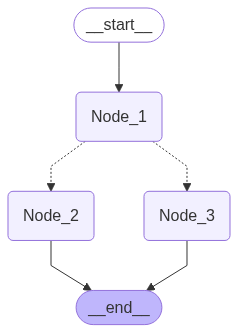

In [24]:
from langgraph.graph import START, END, StateGraph

import random 

def Node_1(state: DataclassState): 
    print("__Node 1__")
    return { "name" :  state.name + " is ..." } 

# Creating function to decide which Node to go among Node 2 and Node 3. 
def decide_node(state: DataclassState) -> Literal["Node_2", "Node_3"]: 

    if random.random() < 0.5:
        return "Node_2"
    
    return "Node_3"

# Create a state graph with TypedDictState
builder = StateGraph(DataclassState) 

# adding nodes
builder.add_node("Node_1", Node_1)
builder.add_node("Node_2", Node_2)
builder.add_node("Node_3", Node_3)

# adding edges
builder.add_edge(START, "Node_1")
builder.add_conditional_edges("Node_1", decide_node)
builder.add_edge("Node_2", END)
builder.add_edge("Node_3", END)

graph = builder.compile()

graph 

### Scenario-1 Invoking graph using correct values

In [25]:
graph.invoke(DataclassState(name="Alice", mood="happy"))

__Node 1__
__Node 3__


{'name': 'Alice is ...', 'mood': 'sad'}

### Scenario-2 Invoking graph using incorrect values

In [28]:
graph.invoke(DataclassState(name="John", mood="good"))

__Node 1__
__Node 3__


{'name': 'John is ...', 'mood': 'sad'}

## 3. Using `pydantic` (Most preferred)

Even though `TypedDict` and `DataClasses` provides type hints, there was no data validation during the runtime.

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations. 

It's particularly well-suited for defining state schemas in LangGraph due to its validation capabilities.

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

In [32]:
from pydantic import BaseModel, field_validator, ValidationError 

# defining the class and extending BaseModel
class PydanticState(BaseModel):
    """A class representing the state of a Pydantic model."""
    name: str
    mood: str

    # validating the mood field 
    @field_validator("mood")
    @classmethod
    def validate_mood(cls, value):
        """Ensure that the mood is either 'happy' or 'sad'."""
        if value not in ["happy", "sad"]:
            raise ValueError("Mood must be either 'happy' or 'sad'.")
        return value
    
try: 
    # creating an instance of PydanticState
    state = PydanticState(name="Alice", mood="good")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Value error, Mood must be either 'happy' or 'sad'. [type=value_error, input_value='good', input_type=str]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error


As shown above, unlike the earlier two schemas, Pydantic is able to do the type safety.